In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

# linear Koopman
from core.koopman_core_linear import KoopDNN as KoopDNN_lin
from core.koopman_core_linear import KoopmanNet as KoopmanNet_lin
from core.koopman_core_linear import KoopmanNetCtrl as KoopmanNetCtrl_lin


# models
from models.koop_model import model_matricies,lift
from dynamics.Vanpol import dynamics_vanpol_data_gen, dynamics_vanpol

## utilities
from core.utility import Output_Con
import control as ct

## OSQP terms
import osqp
import numpy as np
import scipy as sp
from scipy import sparse

## linear Model
from control_files.nmpc_osqp import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics

In [2]:
# Base Parameters
dt = 0.01 #time step
num_snaps = 2000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [3]:
# Oscillator parameters
dyn_pars = {}

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5

dyn_pars['del_a'] = 0.0
dyn_pars['del_b'] = 0.0
dyn_pars['del_c'] = 0.0
dyn_pars['del_d'] = 0.0
dyn_pars['delay'] = False
dyn_pars['delay_time'] = 5
dyn_pars['cont_unc_type'] = 'sinusoidal'

In [4]:
_, X, U = dynamics_vanpol_data_gen(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X.shape, U.shape)

(250, 2001, 2) (250, 2000, 1)


In [5]:
# Check for nan values
print(sum(sum(sum(np.isnan(X)))))

0


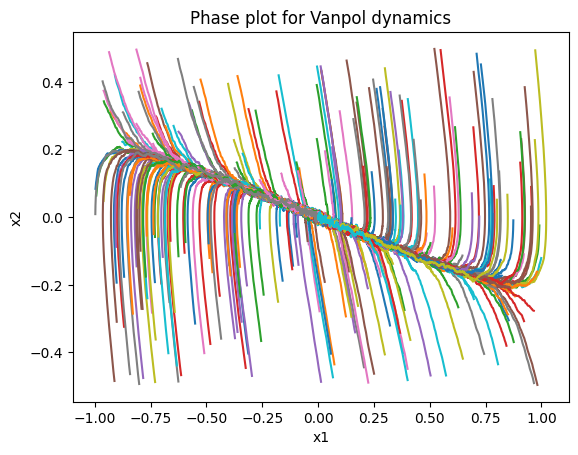

In [6]:
# plot dataset
plt.figure()
plt.title("Phase plot for Vanpol dynamics")
plt.xlabel('x1') 
plt.ylabel('x2')

for i in range(num_traj):
    plt.plot(X[i,:,0], X[i,:,1])

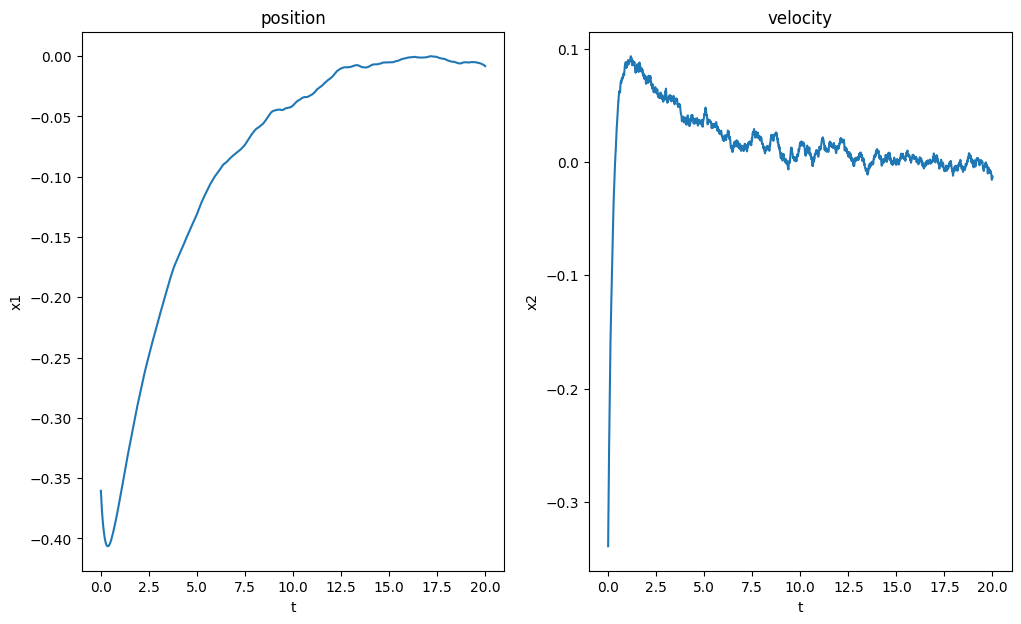

In [7]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("position")
axs[1].set_title("velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X[4,:,0])

axs[1].plot(T, X[4,:,1])


In [8]:
# split training and vaidation datasets
xs_train, us_train = X[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:],U[num_train:,:,:]

In [9]:
# auto encoder parameters for linear

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 20
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 2e-4 # 5e-4
net_params['epochs'] = 300
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = False # this makes the state a part of lifted state
net_params['dt'] = dt


In [ ]:
## linear model Training
train = True

if train == True:
    file = 'saved_models/learned_models/linear_model/vanpol_lin_control_no_state.pth'
    net_lin = KoopmanNetCtrl_lin(net_params)
    model_koop_dnn_lin = KoopDNN_lin(net_lin)
    model_koop_dnn_lin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn_lin.model_pipeline(net_params)
    model_koop_dnn_lin.construct_koopman_model()
    torch.save(model_koop_dnn_lin,file)
else:
    file = 'saved_models/learned_models/linear_model/vanpol_lin_control_state_no_state.pth'
    model_koop_dnn_lin = torch.load(file)

Epoch   1: train loss: 0.6118426323, validation loss: 0.1367347209
Epoch   2: train loss: 0.0686368495, validation loss: 0.0384491850
Epoch   3: train loss: 0.0286282282, validation loss: 0.0193200498
Epoch   4: train loss: 0.0153750200, validation loss: 0.0112565065
Epoch   5: train loss: 0.0088467784, validation loss: 0.0065395196
Epoch   6: train loss: 0.0053845379, validation loss: 0.0049487024
Epoch   7: train loss: 0.0034127547, validation loss: 0.0024631410
Epoch   8: train loss: 0.0022704070, validation loss: 0.0016764338
Epoch   9: train loss: 0.0016043355, validation loss: 0.0012460046
Epoch  10: train loss: 0.0012550749, validation loss: 0.0009929539
Epoch  11: train loss: 0.0010590130, validation loss: 0.0008077099
Epoch  12: train loss: 0.0009524785, validation loss: 0.0008131347
Epoch  13: train loss: 0.0008795953, validation loss: 0.0009282075
Epoch  14: train loss: 0.0008145239, validation loss: 0.0006764253
Epoch  15: train loss: 0.0007687746, validation loss: 0.000620

In [ ]:
train_loss = [l[0] for l in model_koop_dnn_lin.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn_lin.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn_lin.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn_lin.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn_lin.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn_lin.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Learned Model Parameters

## linear Model Parameters

In [ ]:
A = np.array(model_koop_dnn_lin.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn_lin.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn_lin.C)

print(A.shape, B.shape, C.shape)

## Controllabilty

In [ ]:
# define no of observables
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## convert matricies to continious forms
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C


In [ ]:
#check controllability
Con = ct.ctrb(Ac, Bc)
rank = np.linalg.matrix_rank(Con)

print("Controllability for linear Koopman :", rank)


## Output Contrability

In [ ]:
out_con_mat, out_con_rank = Output_Con(Ac,Bc,Cc)


print(out_con_mat.shape)
print(out_con_rank)

## Testing

In [ ]:
# test data parameters
num_snaps_test = 1000  # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples


In [ ]:
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const  

In [ ]:
_, x_test, u_test = dynamics_vanpol_data_gen(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
print(model_koop_dnn_lin.test_loss(x_test,u_test = u_test))

In [ ]:
X_test,_ = model_koop_dnn_lin.net.process(x_test,data_u = u_test)

In [ ]:
x_test = X_test[:, :num_states]
u = X_test[:, num_states:num_states+num_inputs]
x_prime_test = X_test[:,num_states+num_inputs:]

print(x_test.shape, u.shape, x_prime_test.shape)

In [ ]:
z_test = np.empty((n_obs,num_snaps_test+1)).T
x_test_est = np.zeros((num_states,num_snaps_test+1)).T 

z_test[0,:] = lift(x_test[0,:],model_koop_dnn_lin, net_params)
x_test_est[0,:] = x_test[0,:]

In [ ]:
for i in range(num_snaps_test):    
    #linear
    z_test[i+1,:] = np.matmul(z_test[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_test_est[i+1,:] = np.matmul(z_test[i+1,:],C.T)

## Lifting performance

In [ ]:
plt.figure()
plt.plot(T_test[:-1], x_test[:,0],label ='Test data')
plt.plot(T_test, x_test_est[:,0],label = 'estimated')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T_test[:-1],x_test[:,1],label ='Test data')
plt.plot(T_test, x_test_est[:,1],label = 'estimated')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x_test[:,0],x_test[:,1],label ='Test data')
plt.plot(x_test_est[:,0],x_test_est[:,1],label = 'esimated')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()
plt.show()

### Error Evolution

In [ ]:
error_model = np.linalg.norm((x_test_est[:-1,:]-x_test[:,:]),axis=1)

In [ ]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.show()

## Controllers

## Reference Trajectory

In [ ]:
t_ctrl = np.arange(start=0, stop=10, step=dt)
num_snaps_ctrl = t_ctrl.shape[0]

In [ ]:
## linear path
# x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
# x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
# x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

def gen_desired_path(num_states,num_snaps, t_end,shape):
    
    x_ref = np.empty((int(num_states),num_snaps))
    x_ref_dot = np.empty_like(x_ref)
    x_ref_ddot = np.empty_like(x_ref)
    
    arg = np.linspace(0,np.pi,num_snaps)
    
    for i in range(num_snaps):
        if shape == 'linear':
            x_ref[:,i] = arg[i]
            x_ref_dot[:,i] = arg[-1]/t_end
            x_ref_ddot[:,i] = np.zeros(num_states,)
            
        elif shape == 'sinosoidal':
            x_ref[:,i] = np.sin(2*arg[i])
            x_ref_dot[:,i] = (2*arg[-1]/t_end)*np.cos(2*arg[i])
            x_ref_ddot[:,i] = -((2*arg[-1]/t_end)**2)*np.cos(2*arg[i])
        else:
            print('Shape is not defined')
            break
            
            
    return x_ref, x_ref_dot, x_ref_ddot




In [ ]:
x_ref, x_ref_dot, x_ref_ddot = gen_desired_path(int(num_states/2),num_snaps_ctrl, t_ctrl[-1],'sinosoidal')

In [ ]:
x_ref.shape

In [ ]:
x_ref.shape

## ZNN

In [ ]:
gamma = 50

In [ ]:
## specify the matricies
z_ctrl = np.empty((n_obs,num_snaps_ctrl))
x_ctrl = np.empty((num_states,num_snaps_ctrl))
u_ctrl = np.empty((num_inputs,num_snaps_ctrl-1))

## initialize the matricies
x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn_lin, net_params)

In [ ]:
x_ref_full = np.vstack((x_ref,x_ref_dot))
x_ref_dot_full = np.vstack((x_ref_dot,x_ref_ddot))
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(C,Bc)), -np.matmul(C,np.matmul(Ac,z_ctrl[:,i])) + x_ref_dot_full[:,i] - gamma*(x_ctrl[:,i] - x_ref_full[:,i]))
                    
    _,x_ctrl[1,i+1],x_ctrl[0,i+1] = dynamics_vanpol(dt, x_ctrl[0,i],x_ctrl[1,i], u_ctrl[:,i], dyn_pars)
    z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn_lin, net_params)
    

In [ ]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref[0,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[0,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('x')
plt.title('x Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref_dot[0,:],label ='reference')
plt.plot(t_ctrl[:],x_ctrl[1,:],label = 'traced')
plt.xlabel('t')
plt.ylabel('x dot')
plt.title('x dot')
plt.legend()

In [ ]:
plt.figure(figsize=(18, 6)) 
plt.plot(t_ctrl[:-1],u_ctrl[0,:])
plt.xlabel('t')
plt.ylabel('u')
plt.title('u Comparison')

## MPC

In [ ]:
# Create Linear Model Instanse
linear_model = linear_Dynamics(sparse.csc_matrix(A),sparse.csc_matrix(B), C)

# Model parameters
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

## set limits
umax = 10*np.array([1])
umin = -umax

xmax =  10*np.array([1, 1])
xmin = -xmax

In [ ]:
traj_length = num_snaps_ctrl
max_iter = 100
N = 20 #length of horizon
t_eval = dt * np.arange(traj_length+1)          # Simulation time points, closed loop
Q_mpc =  1e5*sparse.eye(num_states)       # State penalty matrix, trajectory generation
QN_mpc = 1e3*sparse.eye(num_states)       # Final state penalty matrix, trajectory generation
R_mpc =  1*sparse.eye(num_inputs)         # Actuation penalty matrix, trajectory generation
R0_mpc = sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
x0 = x_ref_full[:,0]                        
# State constraints, trajectory generation
# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, x0, N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [ ]:
u_init.shape

In [ ]:
x_ref_full[:,0]

In [ ]:
z_init = np.empty((N+1, n_obs))
z0 = lift(x0, model_koop_dnn_lin, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn_lin, net_params)

In [ ]:
z_init.shape

In [ ]:
controller_nmpc = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc.construct_controller(z_init, u_init,x_ref_full[:,0])

In [ ]:
controller_nmpc.trajectory_tracking(x0, z0, x_ref_full.T, max_iter)

In [ ]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref[0,:],label ='reference')
plt.plot(t_eval,controller_nmpc.x_traced[:,0],label = 'traced')
plt.xlabel('t')
plt.ylabel('x')
plt.title('x Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref_dot[0,:],label ='reference')
plt.plot(t_eval,controller_nmpc.x_traced[:,1],label = 'traced')
plt.xlabel('t')
plt.ylabel('x dot')
plt.title('x dot Comparison')
plt.legend()